# La idea de este notebook es explorar el algoritmo de reconstrucción de redes propuesto por https://arxiv.org/pdf/nlin/0111023.pdf
# Nos interesa aplicar esta idea en grafos de palabras, y así reconstruir una lengua desde versiones aleatorias e incluso desde otras lenguas.

## (1) Leemos los datos :)

In [1]:
import pickle

## información sobre familias lingüísticas

families_languages = pickle.load(open('families_languages_sim.p','rb'))

In [2]:
families_languages

{'Jivaroan': ['acu', 'agr', 'jiv'],
 'Panoan': ['amc', 'cbr', 'cbs', 'mcd', 'mcf', 'shp'],
 'Arawakan': ['ame', 'cab', 'cni', 'cot', 'cpu', 'guc', 'not', 'prq'],
 'Harakmbut': ['amr'],
 'Zaparoan': ['arl', 'zro'],
 'Araucanian': ['arn'],
 'Aymara': ['ayr'],
 'Boran': ['boa'],
 'Mayan': ['cak', 'hus', 'kek', 'mam', 'quc', 'toj', 'tzh', 'yua'],
 'Barbacoan': ['cbi', 'cof', 'kwi'],
 'Cahuapanan': ['cbt'],
 'Otomanguean': ['chj', 'csa', 'maz', 'mxv', 'mzi', 'ote', 'zam', 'ztu'],
 'Muskogean': ['cic'],
 'Algic': ['csw', 'mic', 'ojb'],
 'Tacanan': ['ese'],
 'Tupian': ['gug', 'gyr'],
 'Yanomam': ['guu'],
 'Indo-European': ['hns', 'pap'],
 'Huitotoan': ['huu'],
 'Eskimo-Aleut': ['ike', 'kal'],
 'Misumalpan': ['miq'],
 'Mixe-Zoque': ['mto'],
 'Athapaskan-Eyak-Tlingit': ['nav'],
 'Uto-Aztecan': ['nhn', 'ppl'],
 'Quechuan': ['qud',
  'qug',
  'quy',
  'quz',
  'qva',
  'qvc',
  'qvh',
  'qvm',
  'qvn',
  'qwh',
  'qxa',
  'qxn',
  'qxu'],
 'Tucanoan': ['sey', 'snn'],
 'Ticuna-Yuri': ['tca'],
 'Gu

In [3]:
## grafos de palabras

graphs = pickle.load(open('graphs.p','rb'))

## (2) Algunas funciones sobre grafos

In [4]:
## Spectrum :)

from scipy.linalg import eigvalsh
import statsmodels.api as sm
import numpy as np
import networkx as nx

def spectrum(G):
    data=np.array(eigvalsh(nx.normalized_laplacian_matrix(G, weight='weight').todense()))
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw=0.065) # Estimate the densities
    X=np.linspace(0, 2, num=1000)
    prediction=[kde.evaluate(x) for x in X]
    return prediction

In [5]:
def distance(S,T):
    return np.mean([np.abs(x-y) for x,y in zip(S,T)])

In [6]:
## Quechua vs Maya

distance(spectrum(graphs['hus']),spectrum(graphs['cak']))

0.061819334321397315

## (3) Grafiquemos la distribución de valores propios

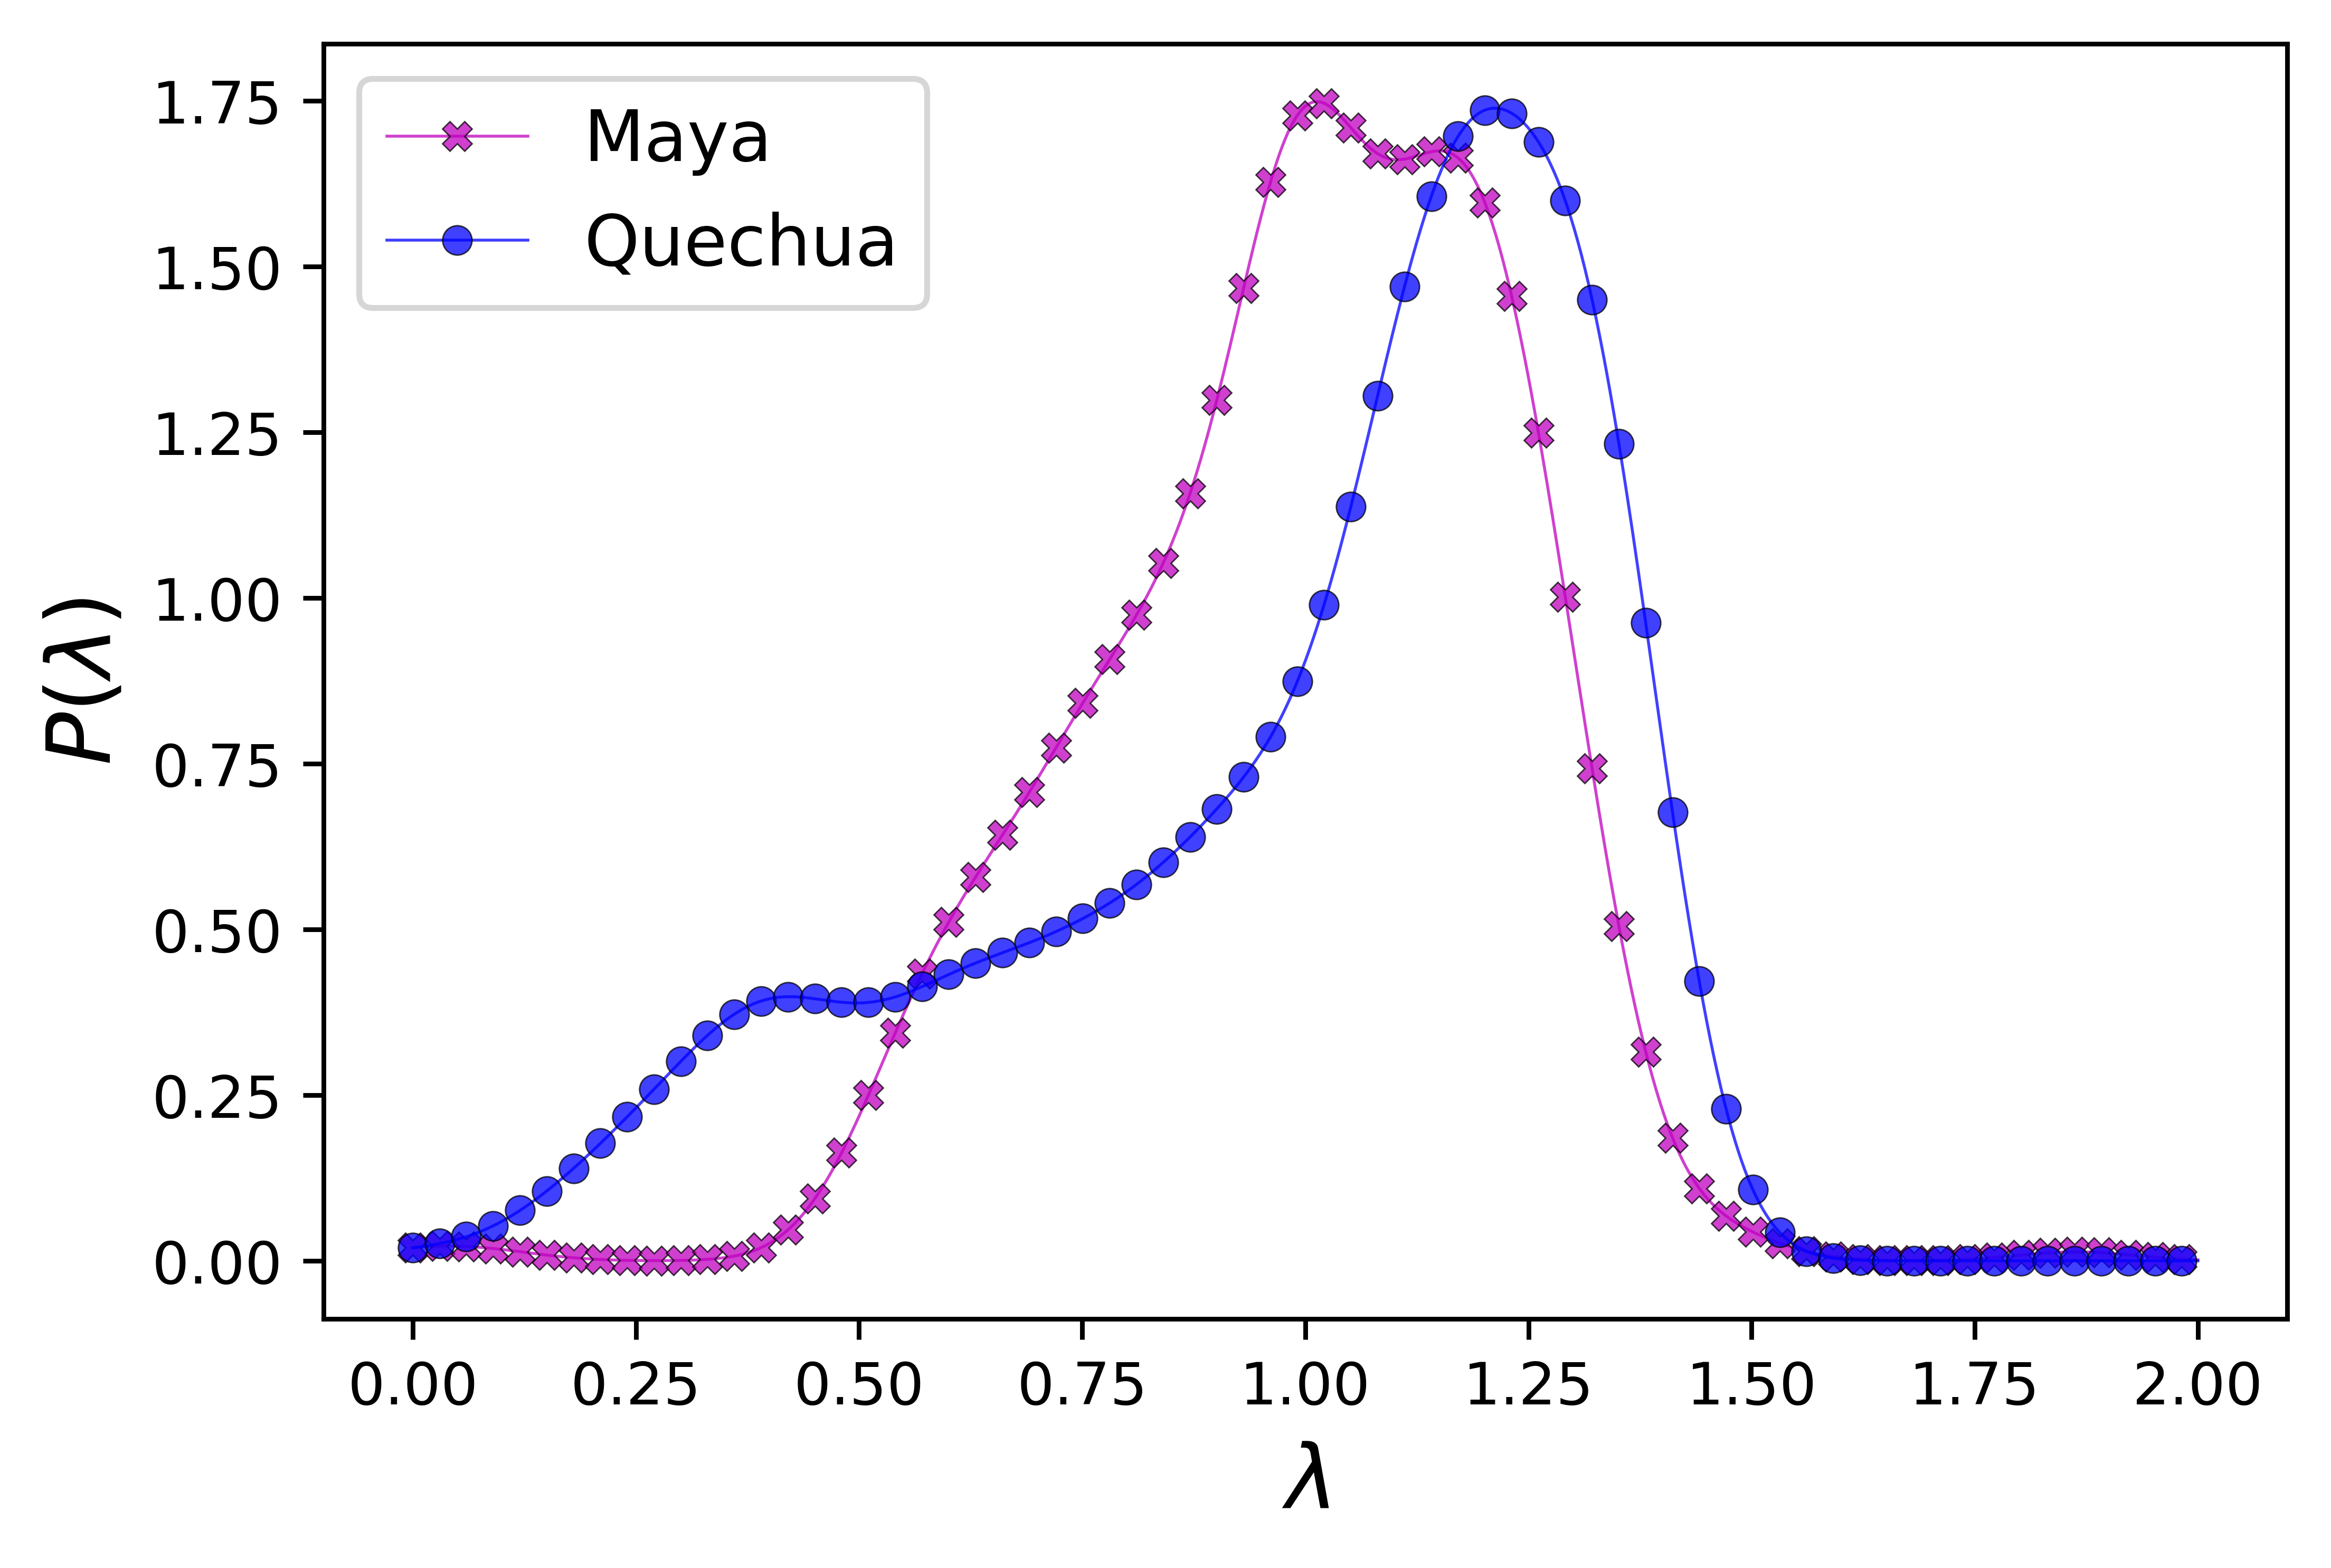

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)

M = spectrum(graphs['cak'])
Q = spectrum(graphs['qud'])

ax.plot(X, M, markevery=15,marker='X',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='m', zorder=10, label='Maya')
ax.plot(X, Q, markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='b', zorder=10, label='Quechua')

plt.legend(loc='upper left',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## (4) Mutación y selección

In [8]:
## mutación
import random

def mutation(G):
    
    Gp = G.copy()
    node = random.choice(list(Gp.nodes()))
    ## remove connections
    nodes = dict(Gp[node]).keys()
    for n in nodes:
        Gp[node][n]['weight']=0
    new_degree = random.randint(1,len(G)-1)
    selected_nodes = random.sample(list(G.nodes()),new_degree)
    for n in selected_nodes:
        Gp.add_edge(node,n,weight=1)
    return Gp

In [9]:
def energy(G):
    S=eigvalsh(nx.normalized_laplacian_matrix(G, weight='weight').todense())
    return sum([np.abs(x-1) for x in S])/float(len(S))

In [10]:
print(energy(graphs['cak']),energy(graphs['qud']))

0.17488138140002507 0.26564161603748665


In [11]:
T=2000

G0 = graphs['cak'] ## Maya
G = graphs['qud'] ## Quechua
G2 = G.copy()
D=[]
Dq=[]
for t in range(T):
    Gp=mutation(G)
    #distancep0=distance(spectrum(Gp),spectrum(G0))
    distanceGG0=distance(spectrum(G),spectrum(G0))
    D+=[distanceGG0]
    energyG0 = energy(G0)
    energyGp = energy(Gp)
    Dq+=[energyGp]
    #if distancep0-distanceGG0<0:
    if distanceGG0 < 0.05:
        G = Gp.copy()
        break
        
    if energyG0 - energyGp < 0:
        G = Gp.copy()
    else:
        if random.random() < 0.001:#np.exp(-(distancep0-distanceGG0)/float(distanceGG0*2)):
            G = Gp.copy()

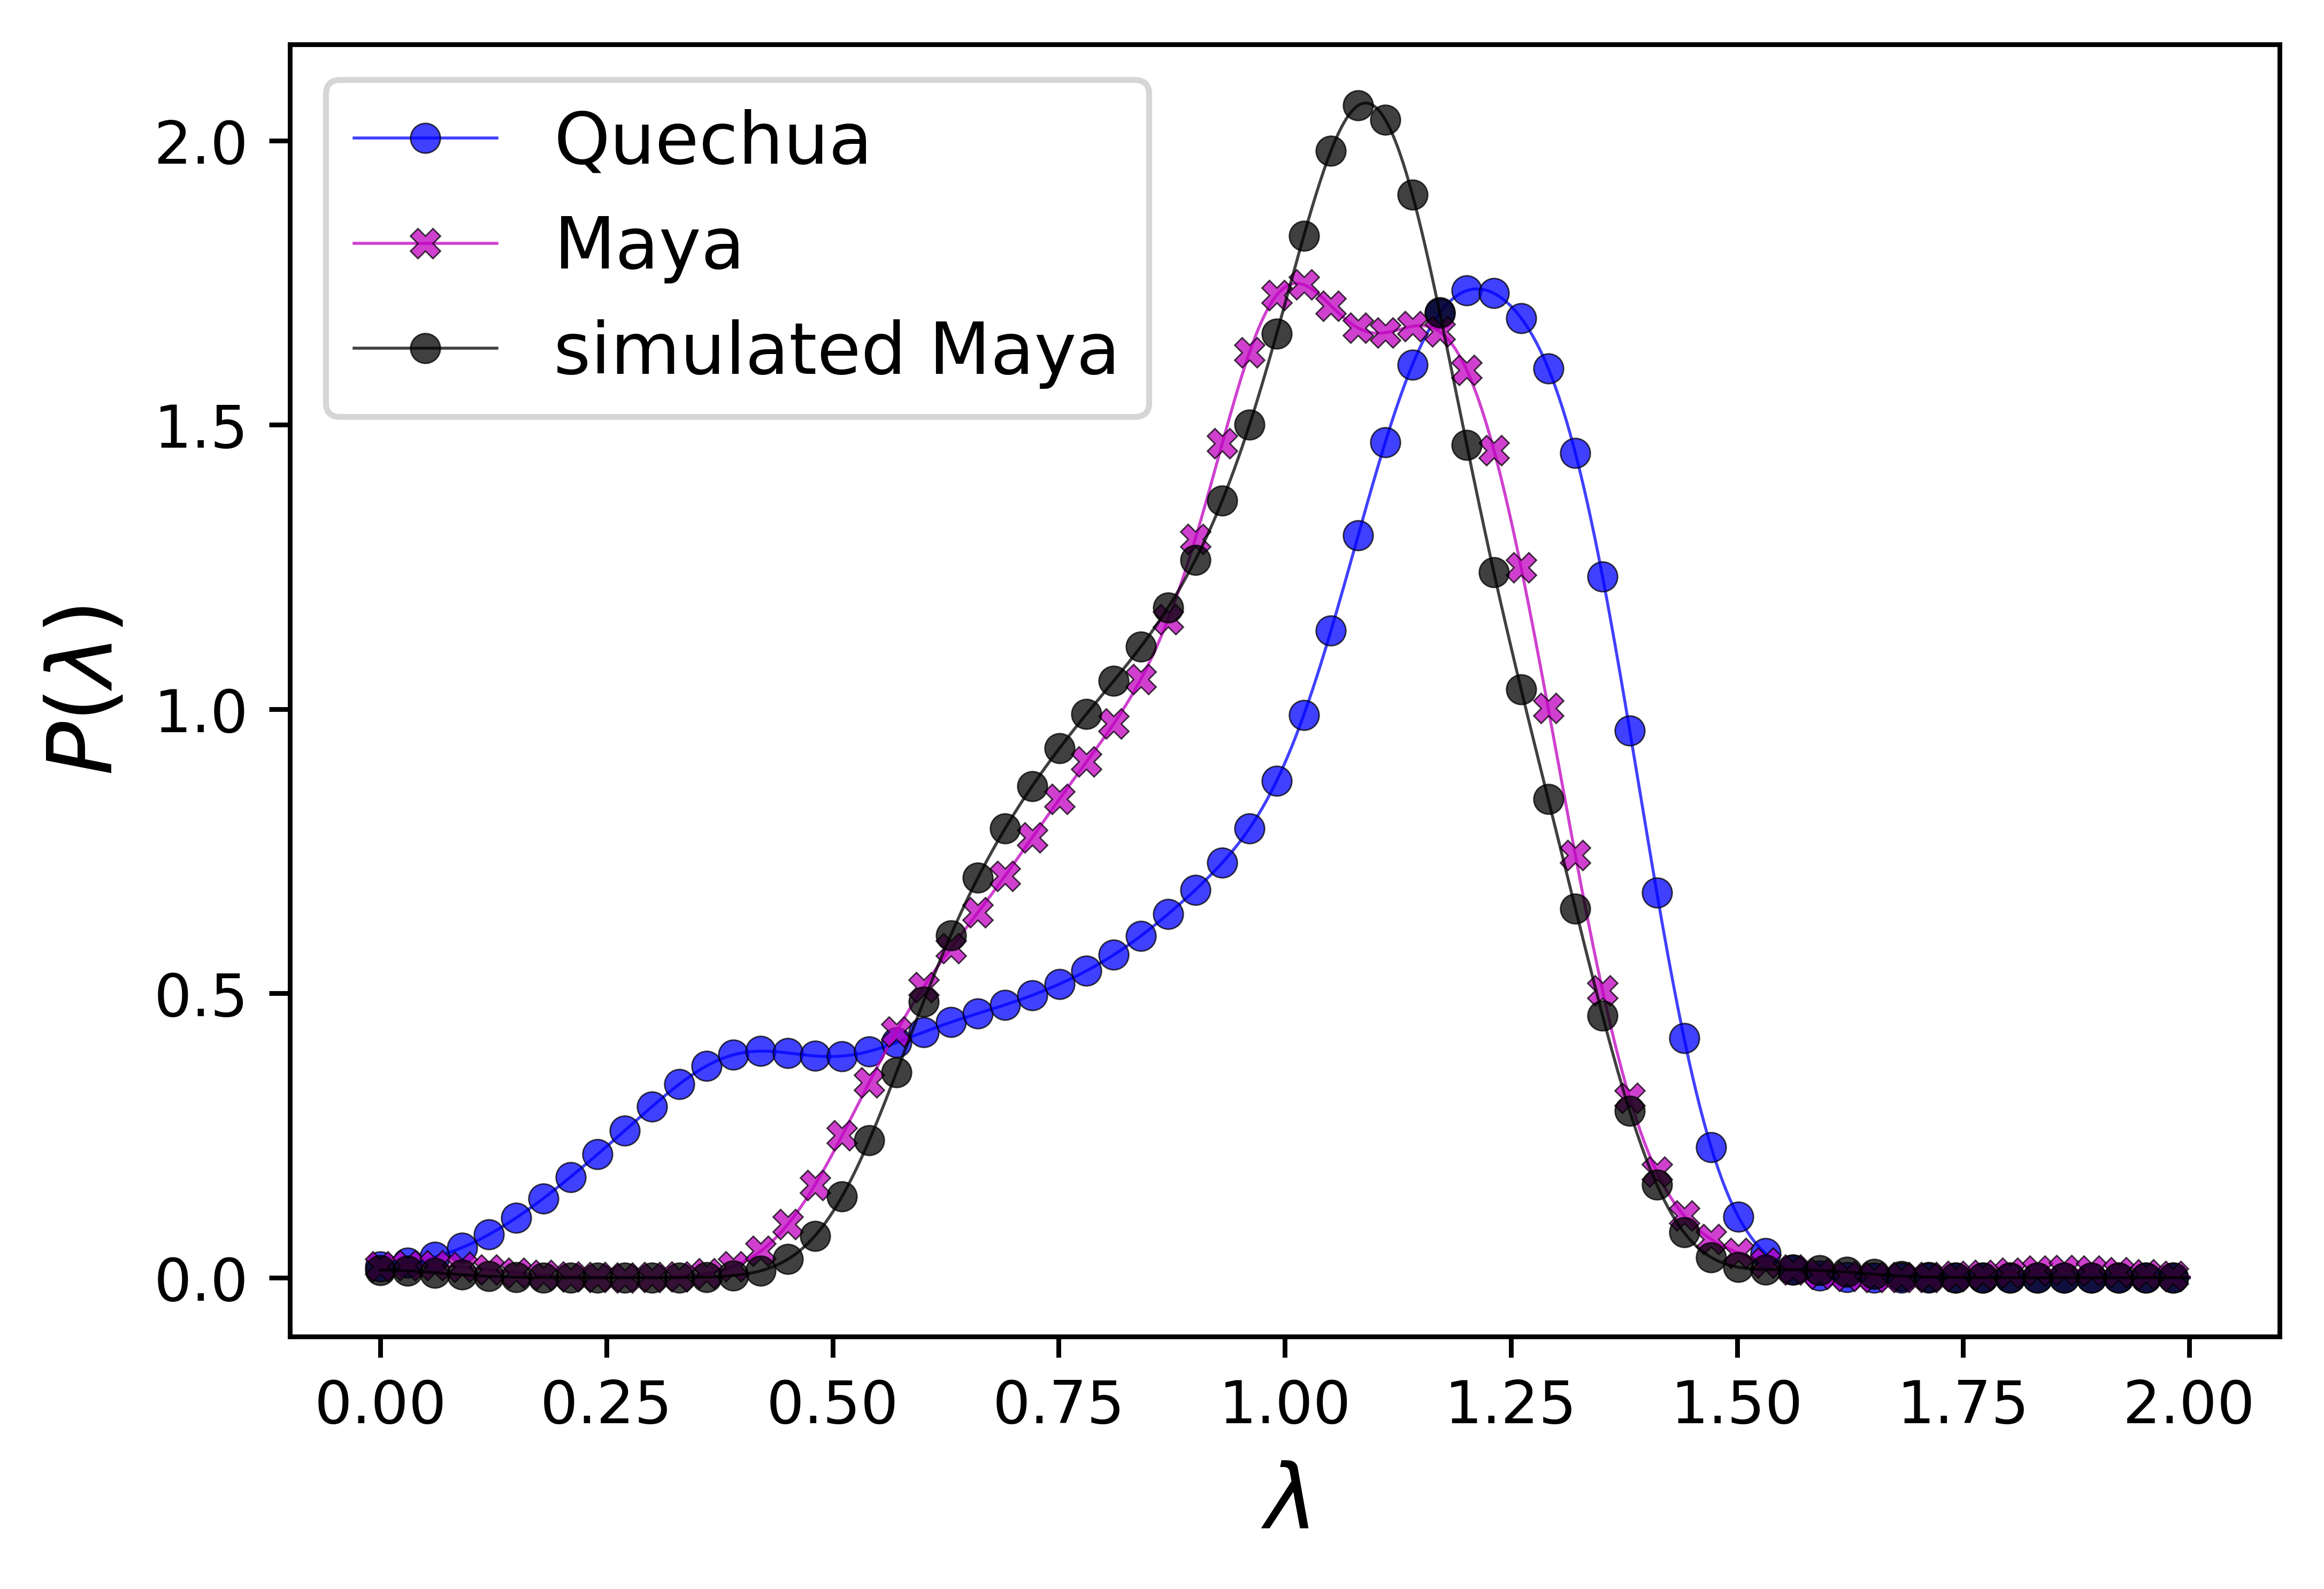

In [12]:
fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)

Q = spectrum(G2)
M = spectrum(G0)
Msim = spectrum(G)

ax.plot(X, Q, markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='b', zorder=10, label='Quechua')
ax.plot(X, M, markevery=15,marker='X',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='m', zorder=10, label='Maya')
ax.plot(X, Msim,markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='k', zorder=10, label='simulated Maya')

plt.legend(loc='upper left',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum_sim_Q.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

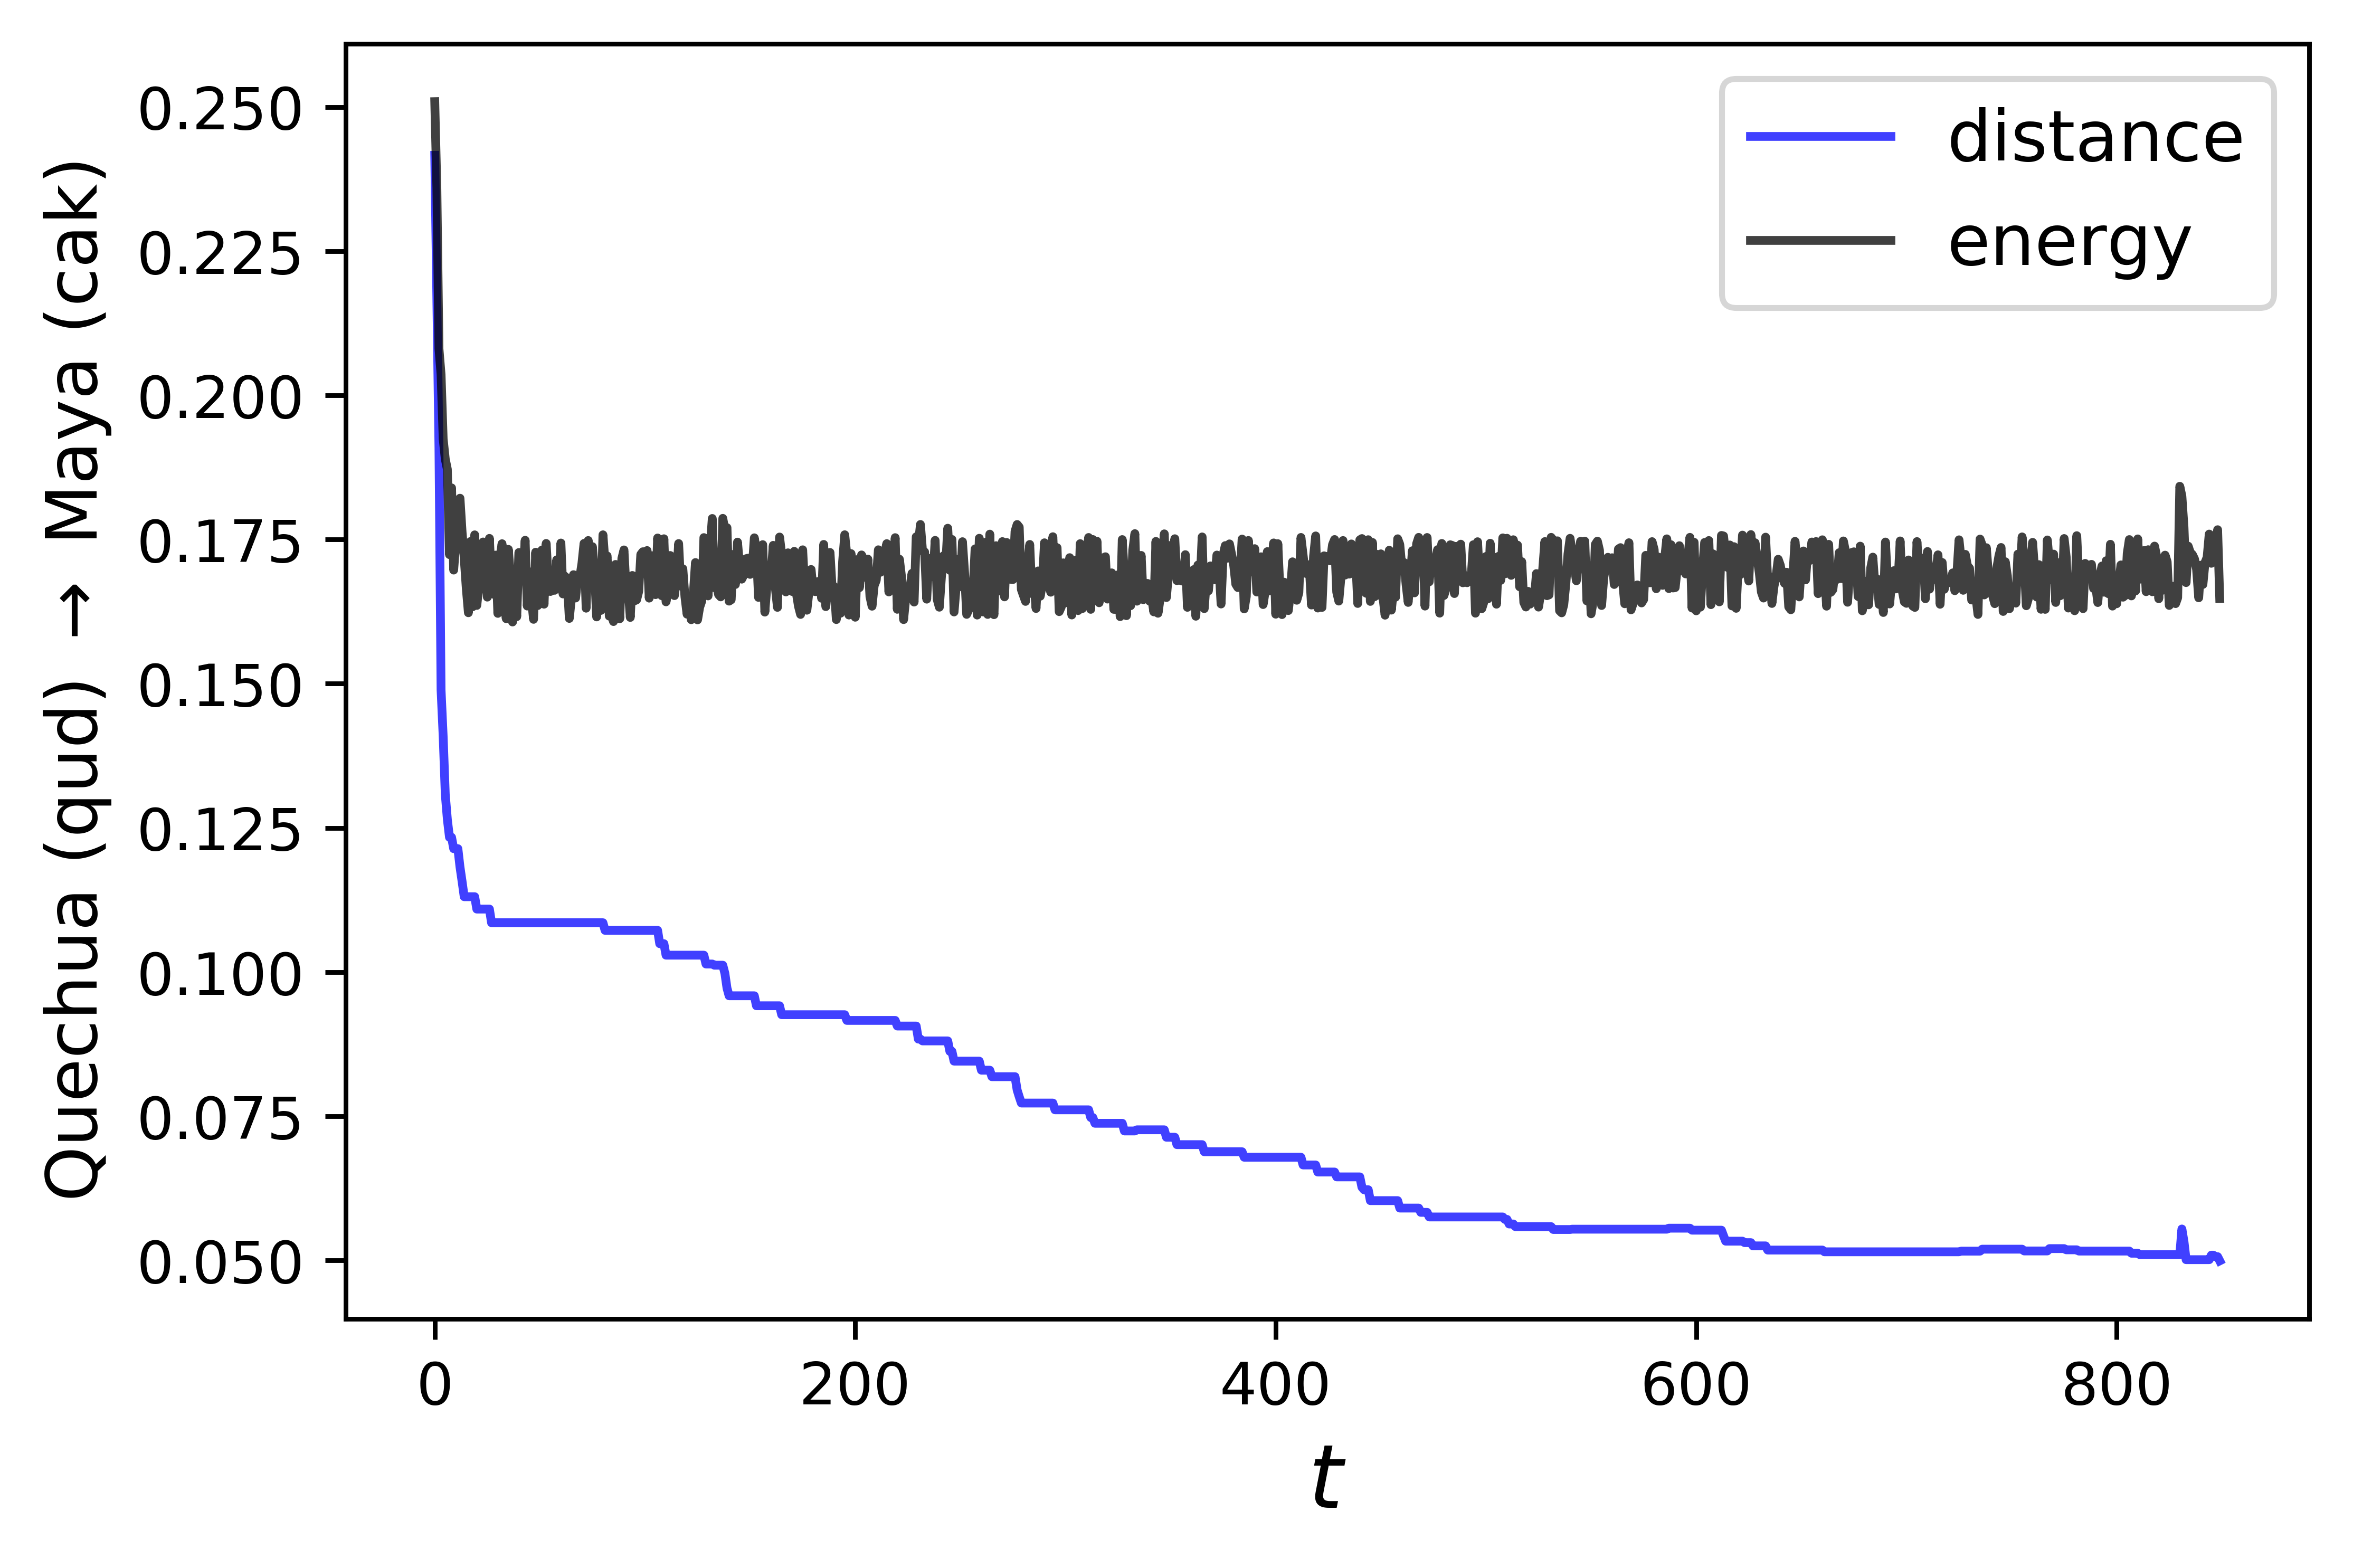

In [13]:
fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)


ax.plot(range(len(D)), D, marker='o',markersize=0,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=1.5, alpha=0.75, color='b', zorder=10, label='distance')
ax.plot(range(len(Dq)), Dq, marker='o',markersize=0,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=1.5, alpha=0.75, color='k', zorder=10, label='energy')

plt.legend(loc='best',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'Quechua (qud) $\rightarrow$ Maya (cak)',fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.savefig('time.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

# Exposición

## (1) Entropía

In [43]:
## textos

spa = 'Todos los seres humanos nacen libres e iguales en dignidad y derechos y, dotados como están de razón y conciencia, deben comportarse fraternalmente los unos con los otros.'
arn = 'Kom pu mogence kisuzuam mvlekey, kom cegeygvn, logkogeygvn ka piwkegeygvn, nieygvn kimvn fey mew mvley tañi yamniewael ka epuñpvle kejuwael egvn.'

In [44]:
spa

'Todos los seres humanos nacen libres e iguales en dignidad y derechos y, dotados como están de razón y conciencia, deben comportarse fraternalmente los unos con los otros.'

In [45]:
arn

'Kom pu mogence kisuzuam mvlekey, kom cegeygvn, logkogeygvn ka piwkegeygvn, nieygvn kimvn fey mew mvley tañi yamniewael ka epuñpvle kejuwael egvn.'

In [46]:
## limpiemos un poco los textos

def tokenize(s):
    return s.split(' ')

def clean(language):
    table = str.maketrans({key: None for key in '``!"#$%&\¿()*+,-./:;<=>?@[\\]_{|}'})
    language=[w.lower().translate(table) for w in tokenize(language)]
    return language

In [47]:
## aplicamos las funciones

spa = clean(spa)
arn = clean(arn)

In [52]:
print(len(spa),len(list(set(spa))))
print(len(arn),len(list(set(arn))))

28 24
21 19


In [53]:
## entropía
from collections import Counter

distributions={}

distributions['spa']=list(dict(Counter(spa)).values())
distributions['arn']=list(dict(Counter(arn)).values())

In [55]:
from scipy.stats import entropy

entropy_languages={}
for language in distributions.keys():
    entropy_languages[language]=entropy(distributions[language],base=2)

In [56]:
entropy_languages

{'spa': 4.467720100474498, 'arn': 4.201841232302569}